In [89]:
import importlib
import parser
import df_parser
import os
importlib.reload(parser)
importlib.reload(df_parser)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from treys import Card, Evaluator

In [90]:
# Load Pluribus data
directory_path = 'phh-dataset\data\pluribus'
tables = os.listdir(directory_path)
table_data = {}

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\2370251135.py:2: SyntaxWarning: invalid escape sequence '\d'
  directory_path = 'phh-dataset\data\pluribus'


In [91]:
# Load a hand example
df_parser.parse_from_file('1.phh')

Player Hole Cards  Preflop   7s9cTc       2c    Pot Size  Profits
0  MrBlonde       Qh5c        f                          1490      -50
1   MrWhite       9h6h       cc   cc, cc    cc, f        1490     -445
2    MrPink       KcJh  cbr 210  cbr 235  cbr 600        1490      495
3   MrBrown       8hQc        f                          1490        0
4  Pluribus       7hKh        f                          1490        0
5    MrBlue       Ks3c        f                          1490        0

In [92]:
# tables_df is a dictionary where the values are a list of data frames (hands)
# each key is a different poker table with varying players
tables_df = {}

for table in tables: 
    directory_path = f'phh-dataset\data\pluribus\{table}'
    hands = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith(".phh"):
            file_path = os.path.join(directory_path, file_name)
            try:
                # Parse the .phh file and add the Hand object to the list
                hand = df_parser.parse_from_file(file_path)
                hands.append(hand)
            except Exception as e:
                print(f"Error parsing file {file_name}: {e}")
    tables_df[table] = hands

<string>:6: SyntaxWarning: invalid escape sequence '\{'
<>:6: SyntaxWarning: invalid escape sequence '\{'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<string>:6: SyntaxWarning: invalid escape sequence '\{'
<>:6: SyntaxWarning: invalid escape sequence '\{'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\353081576.py:6: SyntaxWarning: invalid escape sequence '\{'
  directory_path = f'phh-dataset\data\pluribus\{table}'
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\353081576.py:6: SyntaxWarning: invalid escape sequence '\d'
  directory_path = f'phh-dataset\data\pluribus\{table}'


Error parsing file 0.phh: All arrays must be of the same length
Error parsing file 23.phh: All arrays must be of the same length
Error parsing file 204.phh: All arrays must be of the same length
Error parsing file 88.phh: All arrays must be of the same length
Error parsing file 76.phh: All arrays must be of the same length
Error parsing file 128.phh: All arrays must be of the same length
Error parsing file 43.phh: All arrays must be of the same length
Error parsing file 53.phh: All arrays must be of the same length


In [93]:
tables_df["100"][0]

Player Hole Cards  Preflop 7d5h9d  7c       Qh  Pot Size  Profits
0    MrBlue       TcQc       cc     cc  cc  cbr 230       650      310
1  MrBlonde       8s4c        f                           650     -100
2   MrWhite       9c3d        f                           650        0
3    MrPink       Ah4h  cbr 210     cc  cc        f       650     -210
4   MrBrown       Th5s        f                           650        0
5  Pluribus       6c7s        f                           650        0

In [94]:
# Total number of hands
total_hands = 0
for key, dataframes in tables_df.items():
    for df in dataframes:
        total_hands += 1
total_hands

9992

## Calculating Position

1 - small blind (first to act) \
2 - big blind \
3 - lowjack \
4 - hijack \
5 - cutoff \
6 - button  (last to act)

In [95]:
def position(hand):
    hand["Position"] = hand.index + 1

## Calculating Wetness of Board
[0,1]

In [96]:
def parse_card(card):
    """Parse a card to extract rank and suit."""
    rank_translation = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7,
                        '8': 8, '9': 9, 'T': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14}
    rank = rank_translation[card[:-1]]  # Convert rank to numerical value
    suit = card[-1]  # Last character is the suit ('h', 'd', 'c', 's')
    return rank, suit

def wetness(board):
    parsed_board = [parse_card(card) for card in board]
    ranks = [card[0] for card in parsed_board]
    suits = [card[1] for card in parsed_board]
    ranks.sort()

    suit_counts = Counter(suits)
    flush_score = max(suit_counts.values()) - 2 if max(suit_counts.values()) >= 3 else 0

    # Straight potential
    unique_ranks = sorted(set(ranks))  # Remove duplicates
    straight_score = 0
    for i in range(len(unique_ranks) - 2):  # Check for connectedness
        if unique_ranks[i+1] - unique_ranks[i] <= 1 and unique_ranks[i+2] - unique_ranks[i+1] <= 1:
            straight_score += 1
    if len(unique_ranks) >= 4 and unique_ranks[-1] - unique_ranks[-4] <= 3:
        straight_score += 1

    # Paired cards
    rank_counts = Counter(ranks)
    pairs = sum(1 for count in rank_counts.values() if count >= 2)
    pair_score = pairs

    # High cards
    high_cards = {10, 11, 12, 13, 14}  # 10, J, Q, K, A
    high_card_score = sum(1 for rank in ranks if rank in high_cards) * 0.5

    # Total wetness score
    wetness_score = flush_score + straight_score + pair_score + high_card_score
    return wetness_score

## River Bluff Analysis

Next, we will analyze when Pluribus bluffs on the river

In [97]:
reached_river_hands = []

# Iterate through the entire dictionary
# If Pluribus reaches the river in any hand, append to list
for key, dataframes in tables_df.items():  
    for df in dataframes:  
        if df.shape[1] >= 8:
            if (df["Player"] == "Pluribus").any() and df.iloc[:, 5].any():
                reached_river_hands.append(df)

In [98]:
len(reached_river_hands)

2649

Players reaches the river $\approx$ 26% of the time overall.

In [99]:
pluribus_reach_river_hands = []

for hand in reached_river_hands:
    if hand.loc[hand["Player"] == "Pluribus"].iloc[:,5].any() == True:
        pluribus_reach_river_hands.append(hand)

In [100]:
len(pluribus_reach_river_hands)

877

Pluribus reaches the river 8-9% of the time overall.

## Equity Calculation

In [101]:
pluribus_reach_river_hands[0].iloc[:, 2:5]

Preflop   5d6h2h       3h
0      cc   cc, cc   cc, cc
1      cc  cbr 130  cbr 300
2       f                  
3       f                  
4       f                  
5       f

In [102]:
# We now calculate equity on the river.
evaluator = Evaluator()

river_equities = []

for hand in pluribus_reach_river_hands:
    # Replace "f" with None in specific columns excluding river
    columns_to_replace = hand.iloc[:, 2:5]
    hand.iloc[:, 2:5] = columns_to_replace.applymap(lambda x: None if "f" in str(x) else x)

    # Drop rows with missing values
    showdown = hand.dropna()

    # Extract and verify board cards
    flop = hand.columns[3]  # This might not give card strings
    flop = [flop[0:2], flop[2:4], flop[4:6]]  # Check if slicing works

    turn = [hand.columns[4]]
    river = [hand.columns[5]]
    board = [Card.new(card) for card in flop + turn + river]

    # Calculate equity
    equity = []
    for index, row in showdown.iterrows():
        hole_cards = row["Hole Cards"]
        player_hand = [Card.new(hole_cards[:2]), Card.new(hole_cards[2:])]
        
        player_score = evaluator.evaluate(board, player_hand)
        equity.append(player_score)
    showdown["Equity"] = equity
    river_equities.append(showdown)

C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\1174238548.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  hand.iloc[:, 2:5] = columns_to_replace.applymap(lambda x: None if "f" in str(x) else x)
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\1174238548.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  showdown["Equity"] = equity
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\1174238548.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  hand.iloc[:, 2:5] = columns_to_replace.applymap(lambda x: None if "f" in str(x) else x)
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\1174238548.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [103]:
len(river_equities)

877

In [104]:
# Add wetness feature
for hand in river_equities:
    flop = hand.columns[3]  # This might not give card strings
    flop = [flop[0:2], flop[2:4], flop[4:6]]  # Check if slicing works
    turn = [hand.columns[4]]
    river = [hand.columns[5]]
    board = flop + turn + river
    wetness_score = wetness(board)
    hand["Wetness"] = wetness_score

C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\2754090430.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Wetness"] = wetness_score
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\2754090430.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Wetness"] = wetness_score
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\2754090430.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [105]:
len(river_equities)
river_equities[5]

Player Hole Cards  Preflop   Ad4h2h  2d       Ts  Pot Size  Profits  \
1   MrWhite       6h5s       cc   cc, cc  cc  cbr 500      1450      525   
4  Pluribus       7hKh  cbr 225  cbr 250  cc        f      1450     -475   

   Equity  Wetness  
1    5996      2.0  
4    5968      2.0

In [106]:
# Add bluff label
for hand in river_equities:
    # get pluribus row
    pluribus_row = hand[hand["Player"] == "Pluribus"]
    
    # get river card
    river_card = pluribus_row.columns[5]

    # Check if Pluribus is the one betting/raising
    aggression = False
    if "cbr" in pluribus_row[river_card].values[0]:
        aggression = True

    max_equity_row = hand.loc[hand["Equity"].idxmin()]
    min_equity_row = hand.loc[hand["Equity"].idxmax()]

    # To determine if Pluribus bluffed, he cannot have the highest equity (lower "Equity" value is higher) or equity range is <= 1000
    bluff = 0
    if ((max_equity_row.Player != 'Pluribus' or min_equity_row.Equity - max_equity_row.Equity <= 1000)  and aggression):
        bluff = 1
    hand["Bluff"] = bluff

C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\1699448068.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Bluff"] = bluff
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\1699448068.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Bluff"] = bluff
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\1699448068.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [107]:
len(river_equities)

877

In [108]:
# Add position feature
for hand in river_equities:
    position(hand)

C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\2771689680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Position"] = hand.index + 1
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\2771689680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Position"] = hand.index + 1
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\2771689680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [109]:
len(river_equities)

877

In [114]:
# Pluribus bluffed here
filtered_river_equities = [df for df in river_equities if df["Bluff"].iloc[0] == 1]
print(len(filtered_river_equities))

184


In [130]:
filtered_river_equities[181]

Player Hole Cards  Preflop   3h7s5c            Qs                 6c  \
2  Pluribus       8sAs  cbr 200  cbr 650  cc, cbr 2925  cbr 6225, sm 8sAs   
5      Budd       5h5d       cc       cc   cbr 975, cc        cc, sm 5h5d   

   Pot Size  Profits  Equity  Wetness  Bluff  Position  Pot Odds  
2     21175   -10000    6435      1.5      1         3  0.416388  
5     21175    10250    2229      1.5      1         6  0.416388

In [116]:
river_bluff_percentage = len(filtered_river_equities)/len(river_equities)
river_bluff_percentage

0.20980615735461802

In [128]:
# Total Bluff profits
pluribus_profits = 0
for hand in filtered_river_equities:
    print(hand[hand["Player"] == "Pluribus"]["Profits"].values[0])
    pluribus_profits += hand[hand["Player"] == "Pluribus"]["Profits"].values[0]
pluribus_profits

812
2133
480
1200
250
400
0
-2187
437
4325
-1075
-3705
700
-5830
9462
0
-900
3790
625
525
-3725
525
-1800
650
1859
475
275
475
-10000
775
-2950
-3300
-300
-6250
250
525
400
-949
-2175
375
625
310
1200
-1750
-8362
260
-445
25
-745
-5000
-2090
2753
1400
1120
250
-1662
-1525
650
422
1200
700
-10000
272
1152
525
100
-475
2850
-1847
325
-475
-600
-2200
-500
-599
275
700
-1825
-900
-500
275
-1050
-6725
550
300
475
-2875
-1349
1250
-1775
-2400
450
-425
4199
300
-3199
1947
1013
1217
-2035
272
250
10150
600
795
-10000
-4700
250
-1100
-800
-7700
-600
-3150
575
2525
700
-7675
600
465
250
250
-625
-10000
-1100
100
650
-1400
100
1312
1775
300
1252
850
575
-400
415
550
-500
-1900
-2475
1286
-2375
1712
-475
-10000
-6110
450
50
-725
-750
75
-2360
3700
300
-912
-10000
1025
-1810
525
800
-1000
775
925
275
-2061
600
-800
-1225
1880
75
2775
-10000
-2200
475
419
750
-895
950
600
385
2025
-10000
2275
362


-114459

Out of the 8.81% chance that Pluribus reaches the river, $\approx$ 20%  of the hands he plays contain a bluff.

In [117]:
successful_bluff = []
unsuccessful_bluff = []
for hand in filtered_river_equities:
    for index, row in hand.iterrows():
        if row["Player"] != "Pluribus" and "f" in str(row.iloc[5]):
            successful_bluff.append(hand)
        elif row["Player"] != "Pluribus" and "f" not in str(row.iloc[5]):
            unsuccessful_bluff.append(hand)

In [118]:
print(len(successful_bluff))
print(len(unsuccessful_bluff))

88
103


In [119]:
from collections import Counter
def has_duplicates(lst):
    # Convert DataFrame objects into tuples for hashability
    hashable_lst = [tuple(row) for row in lst]  # Convert rows or DataFrames into tuples
    return len(hashable_lst) != len(set(hashable_lst))

def find_duplicates(lst):
    # Convert rows or DataFrame objects into tuples for hashability
    hashable_lst = [tuple(row) for row in lst]  # Convert rows to tuples
    counter = Counter(hashable_lst)  # Count occurrences of each item
    duplicates = [item for item, count in counter.items() if count > 1]  # Identify duplicates
    return duplicates

# Example: Check for duplicates and find them
if has_duplicates(unsuccessful_bluff):
    duplicates = find_duplicates(unsuccessful_bluff)
    print("Duplicates found:")
    for dup in duplicates:
        print(dup)

In [120]:
filtered_river_equities[6]

Player Hole Cards  Preflop 9hTc9s       Js                6c  Pot Size  \
0  Pluribus       JdQc   cc, cc     cc  cbr 350  cbr 700, sm JdQc      2950   
1    MrBlue       QhJh  cbr 350     cc       cc       cc, sm QhJh      2950   

   Profits  Equity  Wetness  Bluff  Position  
0        0    2844      3.0      1         1  
1        0    2844      3.0      1         2

In [121]:
column_name = river_equities[1][river_equities[1].Player == "Pluribus"].columns[5]
column_name
plur_action = river_equities[1][river_equities[1].Player == "Pluribus"][column_name].values[0]
plur_action

'cbr 800'

In [122]:
for hand in filtered_river_equities:
    river_bet = 0
    column_name = hand[hand.Player == "Pluribus"].columns[5]
    plur_action = hand[hand.Player == "Pluribus"][column_name].values[0]
    plur_action = plur_action.replace(","," ")
    if 'cbr' in plur_action:
        actions = plur_action.split(' ')
        for i,action in enumerate(actions):
            if 'cbr' in action:
                river_bet = int(actions[i + 1])

    # Extract the pot size for Pluribus
    pot_size = hand["Pot Size"].values[0] - river_bet

    # Calculate the river bet size as a ratio
    river_bet_size_ratio = river_bet / pot_size
    hand["Pot Odds"] = river_bet_size_ratio

C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\949439574.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Pot Odds"] = river_bet_size_ratio
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\949439574.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Pot Odds"] = river_bet_size_ratio
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\949439574.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [123]:
filtered_river_equities[1]

Player Hole Cards  Preflop       Qd9d2d        Td        7d  Pot Size  \
1  Pluribus       8s9s       cc  cc, cbr 804  cbr 1054  cbr 2108      6551   
4   MrWhite       9c9h  cbr 225  cbr 277, cc        cc         f      6551   

   Profits  Equity  Wetness  Bluff  Position  Pot Odds  
1     2133    1238      4.0      1         2  0.474454  
4    -2083    1238      4.0      1         5  0.474454

## Now we perform Bayes Decision Rule, using equity on the river as a feature

Calculate $P(\text{Bluff})$, the probability of bluffing on the river. and $P(\text{No Bluff})$. \
Calculate $P(\text{Opponent Folds | Bluff})$, the likelihood that your opponent folds when you bluff and $P(\text{Opponent Folds | No Bluff})$

In [179]:
data = pd.concat(river_equities, ignore_index=True)
important_data = data[["Player", "Hole Cards", "Equity", "Bluff", "Wetness","Position","Profits"]]
plur_data = important_data[important_data["Player"] == "Pluribus"]

In [ ]:
plur_data[data['Bluff'] == 1]

In [ ]:
plur_data[(plur_data['Equity'] < 2000)&(plur_data["Bluff"] == 1)]

In [ ]:
H1_data = plur_data[plur_data['Bluff'] == 1]['Wetness']  # Bluff
H0_data = plur_data[plur_data['Bluff'] == 0]['Wetness']  # Not a Bluff (if available)

# Discretize equity into bins
bins = np.linspace(plur_data['Wetness'].min(), plur_data['Wetness'].max(), 20)  # 20 bins
H1_hist, _ = np.histogram(H1_data, bins=bins, density=True)
H0_hist, _ = np.histogram(H0_data, bins=bins, density=True)

# Normalize histograms to sum to 1
H1_hist = H1_hist / H1_hist.sum()
H0_hist = H0_hist / H0_hist.sum()

# Compute bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the likelihoods
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, H1_hist, label='Bluff (H1)', color='red', linewidth=2)
plt.plot(bin_centers, H0_hist, label='Not Bluff (H0)', color='blue', linewidth=2)
plt.fill_between(bin_centers, H1_hist, color='red', alpha=0.3)
plt.fill_between(bin_centers, H0_hist, color='blue', alpha=0.3)
plt.title('Class Conditional Probabilities: Bluff vs. Not Bluff')
plt.xlabel('Wetness')
plt.ylabel('Normalized Probability')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
H0_data

In [ ]:
H1_data = plur_data[plur_data['Bluff'] == 1]['Equity']  # Bluff
H0_data = plur_data[plur_data['Bluff'] == 0]['Equity']  # Not a Bluff (if available)

# Discretize equity into bins
bins = np.linspace(plur_data['Equity'].min(), plur_data['Equity'].max(), 22)  # 20 bins
H1_hist, _ = np.histogram(H1_data, bins=bins, density=True)
H0_hist, _ = np.histogram(H0_data, bins=bins, density=True)

# Normalize histograms to sum to 1
H1_hist = H1_hist / H1_hist.sum()
H0_hist = H0_hist / H0_hist.sum()

# Compute bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the likelihoods
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, H1_hist, label='Bluff (H1)', color='red', linewidth=2)
plt.plot(bin_centers, H0_hist, label='Not Bluff (H0)', color='blue', linewidth=2)
plt.fill_between(bin_centers, H1_hist, color='red', alpha=0.3)
plt.fill_between(bin_centers, H0_hist, color='blue', alpha=0.3)
plt.title('Class Conditional Probabilities: Bluff vs. Not Bluff')
plt.xlabel('Equity')
plt.ylabel('Normalized Probability')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
H1_data = plur_data[plur_data['Bluff'] == 1]['Position']  # Bluff
H0_data = plur_data[plur_data['Bluff'] == 0]['Position']  # Not a Bluff (if available)

# Discretize equity into bins
bins = np.linspace(plur_data['Position'].min(), plur_data['Position'].max(), 7)  # 20 bins
H1_hist, _ = np.histogram(H1_data, bins=bins, density=True)
H0_hist, _ = np.histogram(H0_data, bins=bins, density=True)

# Normalize histograms to sum to 1
H1_hist = H1_hist / H1_hist.sum()
H0_hist = H0_hist / H0_hist.sum()

# Compute bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the likelihoods
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, H1_hist, label='Bluff (H1)', color='red', linewidth=2)
plt.plot(bin_centers, H0_hist, label='Not Bluff (H0)', color='blue', linewidth=2)
plt.fill_between(bin_centers, H1_hist, color='red', alpha=0.3)
plt.fill_between(bin_centers, H0_hist, color='blue', alpha=0.3)
plt.title('Class Conditional Probabilities: Bluff vs. Not Bluff')
plt.xlabel('Position')
plt.ylabel('Normalized Probability')
plt.legend()
plt.grid(True)
plt.show()

## Turn Bluff Analysis

In [131]:
tables_df["100"][16]

Player Hole Cards  Preflop    Pot Size  Profits
0  Pluribus       8c2s        f         275      -50
1    MrBlue       6c8d        f         275     -100
2  MrBlonde       4h2h        f         275        0
3   MrWhite       9c3c        f         275        0
4    MrPink       4s2d        f         275        0
5   MrBrown       JcTs  cbr 275         275      150

In [134]:
turn_hands = []

# Iterate through the entire dictionary
# If Pluribus reaches the turn in any hand, append to list
for key, dataframes in tables_df.items():  
    for df in dataframes:  
        if df.shape[1] >= 7:
            if (df["Player"] == "Pluribus").any() and df.iloc[:, 4].any():
                turn_hands.append(df)

In [135]:
len(turn_hands)

3774

37.81% likelihood of reaching turn

In [136]:
pluribus_turn_hands = []

for hand in turn_hands:
    if hand.loc[hand["Player"] == "Pluribus"].iloc[:,4].any() == True:
        pluribus_turn_hands.append(hand)

In [137]:
len(pluribus_turn_hands)

1288

In [138]:
pluribus_turn_hands[0].iloc[:, 3:4]

5d6h2h
0   cc, cc
1  cbr 130
2         
3         
4         
5

In [139]:
# We now calculate equity on the turn.
evaluator = Evaluator()

turn_equities = []

for hand in pluribus_turn_hands:
    # Replace "f" with None in specific columns
    columns_to_replace = hand.iloc[:, 3:4]
    hand.iloc[:, 3:4] = columns_to_replace.applymap(lambda x: None if "f" in str(x) else x)

    # Drop rows with missing values
    showdown = hand.dropna()

    # Extract and verify board cards
    flop = hand.columns[3]  # This might not give card strings
    flop = [flop[0:2], flop[2:4], flop[4:6]]  # Check if slicing works

    turn = [hand.columns[4]]
    board = [Card.new(card) for card in flop + turn]

    # Calculate equity
    equity = []
    for index, row in showdown.iterrows():
        hole_cards = row["Hole Cards"]
        player_hand = [Card.new(hole_cards[:2]), Card.new(hole_cards[2:])]
        
        player_score = evaluator.evaluate(board, player_hand)
        equity.append(player_score)
    showdown["Equity"] = equity
    turn_equities.append(showdown)

C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\2736450793.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  hand.iloc[:, 3:4] = columns_to_replace.applymap(lambda x: None if "f" in str(x) else x)
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\2736450793.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  showdown["Equity"] = equity
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\2736450793.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  hand.iloc[:, 3:4] = columns_to_replace.applymap(lambda x: None if "f" in str(x) else x)
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\2736450793.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [140]:
for hand in turn_equities:
    # get pluribus row
    pluribus_row = hand[hand["Player"] == "Pluribus"]
    
    # get turn card
    turn_card = pluribus_row.columns[4]

    # Check if Pluribus is the one betting/raising
    aggression = False
    if "cbr" in pluribus_row[turn_card].values[0]:
        aggression = True

    max_equity_row = hand.loc[hand["Equity"].idxmin()]
    min_equity_row = hand.loc[hand["Equity"].idxmax()]

    # To determine if Pluribus bluffed, he cannot have the highest equity (lower "Equity" value is higher) or equity range is <= 1000
    bluff = 0
    if ((max_equity_row.Player != 'Pluribus' or min_equity_row.Equity - max_equity_row.Equity <= 1000)  and aggression):
        bluff = 1
    hand["Bluff"] = bluff

C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\4239324087.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Bluff"] = bluff
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\4239324087.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Bluff"] = bluff
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\4239324087.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [141]:
# Add wetness feature
for hand in turn_equities:
    flop = hand.columns[3]  # This might not give card strings
    flop = [flop[0:2], flop[2:4], flop[4:6]]  # Check if slicing works
    turn = [hand.columns[4]]
    board = flop + turn
    wetness_score = wetness(board)
    hand["Wetness"] = wetness_score

C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\622554681.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Wetness"] = wetness_score
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\622554681.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Wetness"] = wetness_score
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\622554681.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [142]:
turn_equities[0]

Player Hole Cards Preflop   5d6h2h       3h           Js  Pot Size  \
0  Pluribus       4hAc      cc   cc, cc   cc, cc  cc, sm 4hAc      1160   
1    MrBlue       Ah6s      cc  cbr 130  cbr 300       cc, sm      1160   

   Profits  Equity  Bluff  Wetness  
0      530    1608      0      1.0  
1     -530    5136      0      1.0

In [143]:
# Add position feature
for hand in turn_equities:
    position(hand)

C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\2771689680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Position"] = hand.index + 1
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\2771689680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hand["Position"] = hand.index + 1
C:\Users\xrli2\AppData\Local\Temp\ipykernel_29000\2771689680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [150]:
turn_equities[10]

Player Hole Cards      Preflop    QhKc5h  Ks                 6s  \
4  Pluribus       AsAh  cbr 200, cc  cbr 1925  cc    cc, cc, sm AsAh   
5    MrBlue       5d5c       cc, cc        cc  cc  cbr 6825, sm 5d5c   

   Pot Size  Profits  Equity  Bluff  Wetness  Position  
4     21650   -10000    2468      0      2.5         5  
5     21650    11350     276      0      2.5         6

In [146]:
turn_profits = 0
for hand in turn_equities:
    print(hand[hand["Player"] == "Pluribus"]["Profits"].values[0])
    turn_profits += hand[hand["Player"] == "Pluribus"]["Profits"].values[0]
turn_profits

530
550
350
250
812
-475
275
2133
420
1150
-10000
480
-200
-225
-500
-1435
-200
-475
300
-1050
1200
-1155
1950
300
300
-200
-310
250
2025
4535
400
1875
750
-200
-100
-575
-875
-200
0
2550
3199
-250
-2187
437
-250
-2575
-600
-450
-620
1700
-1025
-10000
-525
200
0
-1250
275
350
-210
4325
-600
1870
-250
-200
-1075
-3705
400
-225
-225
300
-550
-225
-4550
700
200
775
-5830
9462
925
6175
6275
200
-1312
1150
3405
525
-2787
0
-900
-200
300
3790
475
625
-225
-1000
250
1255
400
-250
675
525
10360
900
-3725
1410
475
-587
7925
-475
525
362
1252
-600
1585
300
-1800
-799
650
1859
2250
800
-400
475
-400
-599
525
-225
-225
-275
-1850
650
2250
275
-1200
-2475
475
250
250
3000
2450
500
-10000
2212
1950
775
400
200
-200
-3500
325
400
-925
400
-287
-200
200
275
-525
500
250
-2950
950
-300
450
1412
-800
2025
-961
810
-200
-670
1882
-687
275
-3300
25
-225
-300
-425
900
275
-975
-6250
25
275
275
675
-225
4850
2051
-550
-2400
-250
-2225
350
-450
250
-250
-400
-475
-200
2325
525
-475
-200
525
-1100
400
-250
-9

-53808

In [152]:
turn_data = pd.concat(turn_equities, ignore_index=True)
turn_features = turn_data[["Player", "Hole Cards", "Equity", "Bluff", "Wetness","Position","Profits"]]
plur_turn_data = turn_features[turn_features["Player"] == "Pluribus"]

In [178]:
plur_turn_data[(plur_turn_data['Bluff'] == 1)]['Profits'].sum()

-49796

In [175]:
plur_turn_data[(plur_turn_data['Bluff'] == 1) & (plur_turn_data['Profits'] > 0)]['Profits'].sum()

161862

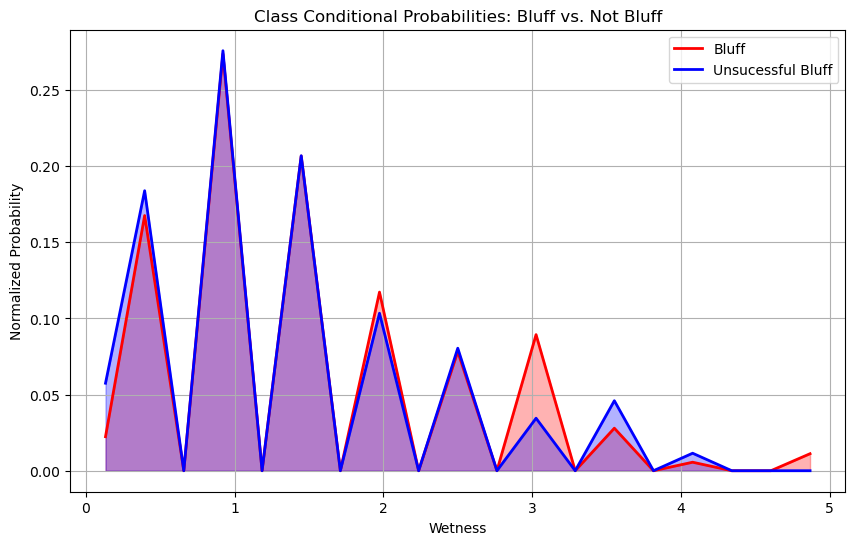

In [174]:
H1_data = plur_turn_data[(plur_turn_data['Bluff'] == 1) & (plur_turn_data['Profits'] > 0)]['Wetness']  # Successful Bluff
H0_data = plur_turn_data[(plur_turn_data['Bluff'] == 1) & (plur_turn_data['Profits'] <= 0)]['Wetness']  # Unsuccessful Bluff 

# Discretize equity into bins
bins = np.linspace(plur_turn_data['Wetness'].min(), plur_turn_data['Wetness'].max(), 20)  # 20 bins
H1_hist, _ = np.histogram(H1_data, bins=bins, density=True)
H0_hist, _ = np.histogram(H0_data, bins=bins, density=True)

# Normalize histograms to sum to 1
H1_hist = H1_hist / H1_hist.sum()
H0_hist = H0_hist / H0_hist.sum()

# Compute bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the likelihoods
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, H1_hist, label='Bluff', color='red', linewidth=2)
plt.plot(bin_centers, H0_hist, label='Unsucessful Bluff', color='blue', linewidth=2)
plt.fill_between(bin_centers, H1_hist, color='red', alpha=0.3)
plt.fill_between(bin_centers, H0_hist, color='blue', alpha=0.3)
plt.title('Class Conditional Probabilities: Bluff vs. Not Bluff')
plt.xlabel('Wetness')
plt.ylabel('Normalized Probability')
plt.legend()
plt.grid(True)
plt.show()

In [161]:
H0_data.shape

(569,)

In [162]:
H1_data.shape

(179,)

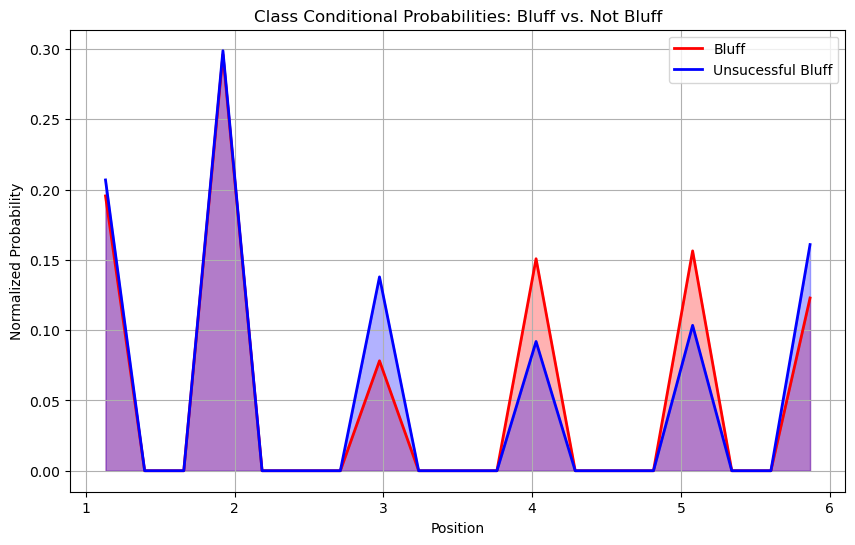

In [172]:
H1_data = plur_turn_data[(plur_turn_data['Bluff'] == 1) & (plur_turn_data['Profits'] > 0)]['Position']  # Bluff
H0_data = plur_turn_data[(plur_turn_data['Bluff'] == 1) & (plur_turn_data['Profits'] <= 0)]['Position']  # Not a Bluff (if available)

# Discretize equity into bins
bins = np.linspace(plur_turn_data['Position'].min(), plur_turn_data['Position'].max(), 20)  # 20 bins
H1_hist, _ = np.histogram(H1_data, bins=bins, density=True)
H0_hist, _ = np.histogram(H0_data, bins=bins, density=True)

# Normalize histograms to sum to 1
H1_hist = H1_hist / H1_hist.sum()
H0_hist = H0_hist / H0_hist.sum()

# Compute bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the likelihoods
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, H1_hist, label='Bluff', color='red', linewidth=2)
plt.plot(bin_centers, H0_hist, label='Unsucessful Bluff', color='blue', linewidth=2)
plt.fill_between(bin_centers, H1_hist, color='red', alpha=0.3)
plt.fill_between(bin_centers, H0_hist, color='blue', alpha=0.3)
plt.title('Class Conditional Probabilities: Bluff vs. Not Bluff')
plt.xlabel('Position')
plt.ylabel('Normalized Probability')
plt.legend()
plt.grid(True)
plt.show()

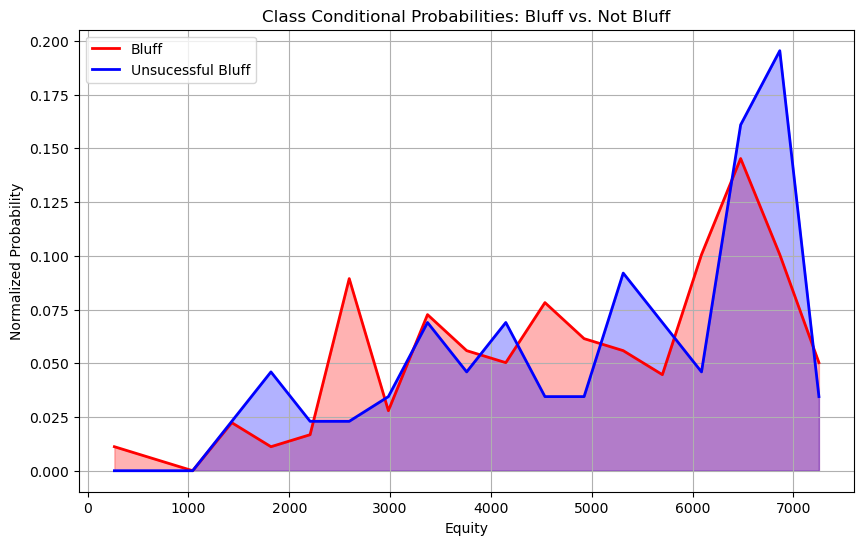

In [173]:
H1_data = plur_turn_data[(plur_turn_data['Bluff'] == 1) & (plur_turn_data['Profits'] > 0)]['Equity']  # Bluff
H0_data = plur_turn_data[(plur_turn_data['Bluff'] == 1) & (plur_turn_data['Profits'] <= 0)]['Equity']  # Unsucessful Bluff (if available)

# Discretize equity into bins
bins = np.linspace(plur_turn_data['Equity'].min(), plur_turn_data['Equity'].max(), 20)  # 20 bins
H1_hist, _ = np.histogram(H1_data, bins=bins, density=True)
H0_hist, _ = np.histogram(H0_data, bins=bins, density=True)

# Normalize histograms to sum to 1
H1_hist = H1_hist / H1_hist.sum()
H0_hist = H0_hist / H0_hist.sum()

# Compute bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the likelihoods
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, H1_hist, label='Bluff', color='red', linewidth=2)
plt.plot(bin_centers, H0_hist, label='Unsucessful Bluff', color='blue', linewidth=2)
plt.fill_between(bin_centers, H1_hist, color='red', alpha=0.3)
plt.fill_between(bin_centers, H0_hist, color='blue', alpha=0.3)
plt.title('Class Conditional Probabilities: Bluff vs. Not Bluff')
plt.xlabel('Equity')
plt.ylabel('Normalized Probability')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
for table in tables:
    directory_path = f'phh-dataset\data\pluribus\{table}'
    hands = []
    for file_name in os.listdir(directory_path):
        # Check if the file has a .phh extension
        if file_name.endswith(".phh"):
            file_path = os.path.join(directory_path, file_name)
            try:
                # Parse the .phh file and add the Hand object to the list
                hand = parser.Hand.parse_from_file(file_path)
                hands.append(hand)
            except Exception as e:
                print(f"Error parsing file {file_name}: {e}")
    table_data[table] = hands

In [ ]:
table_data.keys()

In [ ]:
cum_profits = np.zeros(len(table_data.keys()))
for i, table in enumerate(table_data.keys()):
    plur = table_data[table][0].players.index("Pluribus")
    cum_profit = 0
    for j, hand in enumerate(table_data[table]):
        plur = (plur + j) % 6
        cum_profit += hand.profits[plur]
    cum_profits[i] = cum_profit

In [ ]:
len(cum_profits)

In [ ]:
cum_profits

In [ ]:
np.sum(cum_profits)